# Outline

1. Loading datasets - Transforming images
2. VGG-16 with modification to network-head
3. Using pre-trained models
4. Storing intermediate models
5. Resnet
6. Inception V3
7. Examples

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models

import copy
import warnings

warnings.filterwarnings('ignore')

D:\ProgramData\Miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#hyperparameter tuning
import mlflow
import mlflow.pytorch

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Deep CNNs - VGG16, Resnet, Inception, Squeezenet

## Functions

In [ ]:
def evaluation(dataloader, model):
  total, correct = 0,0
  for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    pred = torch.argmax(outputs.data, axis=1)
    total += labels.shape[0]
    correct += (pred==labels).sum().item()
  
  return 100*correct/total

def fit(model, epochs=16, evaluation = evaluation):
  global best_model
  max_epochs = epochs
  losses = []
  i=0
  i_max = np.ceil(50000/batch_size)
  min_loss = 1000

  for epoch in range(1,max_epochs+1):
    i=0
    for inputs, labels in trainloader:
      i+=1
      inputs, labels = inputs.to(device), labels.to(device)

      opt.zero_grad()    
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      loss.backward()
      opt.step()

      # saving best model
      if loss.item()<min_loss:
        min_loss = loss.item()
        best_model = copy.deepcopy(model.state_dict())
        print(f'minimum loss : {min_loss}')

      del inputs, labels, outputs
      torch.cuda.empty_cache()

      if i%100 == 0:
        losses.append(loss.item())
        print(f'iteration {i}/{i_max},epoch {epoch}/{max_epochs}, loss: {loss.item()}')
    
    # losses.append(loss.item())
    print(f'Epoch {epoch}/{max_epochs}, train acc : {evaluation(trainloader, model):0.2f} test acc : {evaluation(testloader, model):0.2f}')

  plt.plot(losses)
  plt.show()

# Inception
def evaluation_inception(dataloader, model):
  total, correct = 0,0
  for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs, aux_outputs = model(inputs)
    pred = torch.argmax(outputs.data, axis=1)
    total += labels.shape[0]
    correct += (pred==labels).sum().item()
  
  return 100*correct/total

def fit_inception(model, epochs=16, evaluation = evaluation_inception):
  global best_model
  max_epochs = epochs
  losses = []
  i=0
  i_max = np.ceil(50000/batch_size)
  min_loss = 1000

  for epoch in range(1,max_epochs+1):
    i=0
    for inputs, labels in trainloader:
      i+=1
      inputs, labels = inputs.to(device), labels.to(device)

      opt.zero_grad()    
      outputs, aux_outputs = model(inputs)
      loss = loss_fn(outputs, labels) + 0.3*loss_fn(aux_outputs, labels)
      loss.backward()
      opt.step()

      # saving best model
      if loss.item()<min_loss:
        min_loss = loss.item()
        best_model = copy.deepcopy(model.state_dict())
        print(f'minimum loss : {min_loss}')

      del inputs, labels, outputs
      torch.cuda.empty_cache()

      if i%100 == 0:
        losses.append(loss.item())
        print(f'iteration {i}/{i_max},epoch {epoch}/{max_epochs}, loss: {loss.item()}')
    
    # losses.append(loss.item())
    print(f'Epoch {epoch}/{max_epochs}, train acc : {evaluation(trainloader, model):0.2f} test acc : {evaluation(testloader, model):0.2f}')

  plt.plot(losses)
  plt.show()

## Data loading and Visualisation

In [ ]:
transform_train = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) # (mean of R,G,B), (std of R,G,B)
                                      ])
transform_test = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                      ])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./', 
                                        train=True,
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./', 
                                        train=False,
                                        download=True, 
                                        transform=transform_test)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [ ]:
num_classes = 10
batch_size = 4

In [ ]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
images, labels = next(iter(trainloader))
print(images.shape)
print(labels.shape)

torch.Size([4, 3, 224, 224])
torch.Size([4])


In [ ]:
def imshow(img, title):
  npimg = img.numpy()/2 + 0.5 # img * std + mean (un normalising)
  plt.figure(figsize=(batch_size, 1))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.title(title)
  plt.show()

def imbatch_show(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title=[str(x.item()) for x in labels])

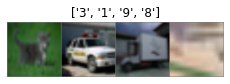

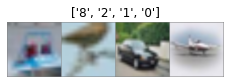

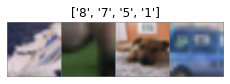

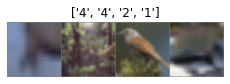

In [ ]:
for i in range(4):
  imbatch_show(trainloader)

## VGG-16

https://pytorch.org/vision/stable/models.html

https://pytorch.org/vision/0.8/_modules/torchvision/models/vgg.html

In [ ]:
vgg = models.vgg16_bn()
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
print(vgg.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [ ]:
vgg.features[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
vgg.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
list(vgg.classifier.children())[:-1]

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False)]

In [ ]:
# modifying output
final_in_features = vgg.classifier[6].in_features #num of input features for last layer
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
vgg.classifier = nn.Sequential(*mod_classifier)
mod_classifier

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=10, bias=True)]

In [ ]:
# modifying output while making network:
vgg_ = models.vgg16_bn(num_classes=10)
print(vgg_.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


## Train VGG with CIFAR10

In [ ]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
def evaluation(dataloader, model):
  total, correct = 0,0
  for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    pred = torch.argmax(outputs.data, axis=1)
    total += labels.shape[0]
    correct += (pred==labels).sum().item()
  
  return 100*correct/total

In [ ]:
#training arc
def fit(model, epochs=16):
  max_epochs = epochs
  losses = []
  i=0
  i_max = np.ceil(50000/batch_size)

  for epoch in range(1,max_epochs+1):
    for inputs, labels in trainloader:
      i+=1
      inputs, labels = inputs.to(device), labels.to(device)

      opt.zero_grad()    
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      loss.backward()
      opt.step()

      del inputs, labels, outputs
      torch.cuda.empty_cache()

      if i%100 == 0:
        losses.append(loss.item())
        print(f'iteration {i}/{i_max},epoch {epoch}/{max_epochs}, loss: {loss.item()}')
    
    # losses.append(loss.item())
    print(f'Epoch {epoch}/{max_epochs}, train acc : {evaluation(trainloader, vgg):0.2f} test acc : {evaluation(testloader, vgg):0.2f}')

  plt.plot(losses)
  plt.show()

In [ ]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [ ]:
# for i,data in enumerate(trainloader,0):
#       pass
# print(i)

3124


In [ ]:
fit(vgg, epochs=16)

iteration 100,epoch 1/16, loss: 4.857359886169434
iteration 200,epoch 1/16, loss: 2.4416513442993164
iteration 300,epoch 1/16, loss: 2.5471861362457275
iteration 400,epoch 1/16, loss: 2.2720489501953125
iteration 500,epoch 1/16, loss: 2.187591314315796
iteration 600,epoch 1/16, loss: 2.2634313106536865
iteration 700,epoch 1/16, loss: 2.3833277225494385
iteration 800,epoch 1/16, loss: 2.308864116668701
iteration 900,epoch 1/16, loss: 2.2526168823242188
iteration 1000,epoch 1/16, loss: 2.303001880645752
iteration 1100,epoch 1/16, loss: 2.2075588703155518
iteration 1200,epoch 1/16, loss: 2.324376344680786
iteration 1300,epoch 1/16, loss: 2.314789295196533
iteration 1400,epoch 1/16, loss: 2.3154304027557373
iteration 1500,epoch 1/16, loss: 2.3045074939727783
iteration 1600,epoch 1/16, loss: 2.308746337890625
iteration 1700,epoch 1/16, loss: 2.3142952919006348
iteration 1800,epoch 1/16, loss: 2.310586929321289


KeyboardInterrupt: ignored

## Freeze Layers for Convolutional Operations

In [ ]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
vgg = models.vgg16_bn(pretrained=True)

In [ ]:
# freeze all layers
for param in vgg.parameters():
  param.requires_grad=False

In [ ]:
# unfreeze last layer
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [ ]:
for param in vgg.parameters():
  if param.requires_grad is True:
    print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [ ]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [ ]:
fit(vgg, epochs=16)

minimum loss : 2.2470903396606445
minimum loss : 2.1855950355529785
minimum loss : 2.1606078147888184
minimum loss : 2.1348509788513184
minimum loss : 2.0996086597442627
minimum loss : 1.6845552921295166
minimum loss : 1.5014524459838867
minimum loss : 1.4423887729644775
minimum loss : 1.3284789323806763
minimum loss : 0.8381414413452148
iteration 100/3125.0,epoch 1/16, loss: 1.5594923496246338
iteration 200/3125.0,epoch 1/16, loss: 2.5086541175842285
iteration 300/3125.0,epoch 1/16, loss: 1.8894236087799072
iteration 400/3125.0,epoch 1/16, loss: 1.5930508375167847
iteration 500/3125.0,epoch 1/16, loss: 2.7062642574310303
iteration 600/3125.0,epoch 1/16, loss: 2.4532554149627686
iteration 700/3125.0,epoch 1/16, loss: 2.200143337249756
iteration 800/3125.0,epoch 1/16, loss: 1.9370081424713135
iteration 900/3125.0,epoch 1/16, loss: 1.4205302000045776
iteration 1000/3125.0,epoch 1/16, loss: 3.3572397232055664
minimum loss : 0.7931846976280212
iteration 1100/3125.0,epoch 1/16, loss: 2.5346

KeyboardInterrupt: ignored

## Checkpointing

In [ ]:
def fit(model, epochs=16, evaluation = evaluation):
  global best_model
  max_epochs = epochs
  losses = []
  i=0
  i_max = np.ceil(50000/batch_size)
  min_loss = 1000

  for epoch in range(1,max_epochs+1):
    i=0
    for inputs, labels in trainloader:
      i+=1
      inputs, labels = inputs.to(device), labels.to(device)

      opt.zero_grad()    
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      loss.backward()
      opt.step()

      # saving best model
      if loss.item()<min_loss:
        min_loss = loss.item()
        best_model = copy.deepcopy(model.state_dict())
        print(f'minimum loss : {min_loss}')

      del inputs, labels, outputs
      torch.cuda.empty_cache()

      if i%100 == 0:
        losses.append(loss.item())
        print(f'iteration {i}/{i_max},epoch {epoch}/{max_epochs}, loss: {loss.item()}')
    
    # losses.append(loss.item())
    print(f'Epoch {epoch}/{max_epochs}, train acc : {evaluation(trainloader, model):0.2f} test acc : {evaluation(testloader, model):0.2f}')

  plt.plot(losses)
  plt.show()

In [ ]:
fit(vgg, epochs=16)

In [ ]:
vgg.load_state_dict(best_model)
print(f'train acc : {evaluation(trainloader, vgg):0.2f} test acc : {evaluation(testloader, vgg):0.2f}')

NameError: ignored

## ResNet - has identity maping

https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html

In [ ]:
resnet = models.resnet18(pretrained=True)
print(resnet)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in resnet.parameters():
  param.requires_grad = False

In [ ]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [ ]:
for param in resnet.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [ ]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01)

minimum loss : 2.613476514816284
minimum loss : 2.4110560417175293
minimum loss : 2.2931690216064453
minimum loss : 2.188577651977539
minimum loss : 2.1518654823303223
minimum loss : 2.0043272972106934
minimum loss : 1.9328067302703857
minimum loss : 1.9184114933013916
minimum loss : 1.9045534133911133
minimum loss : 1.6980905532836914
minimum loss : 1.693256139755249
minimum loss : 1.6908456087112427
minimum loss : 1.638852596282959
iteration 100/3125.0,epoch 1/4, loss: 1.7787598371505737
minimum loss : 1.435631513595581
minimum loss : 1.3959623575210571
minimum loss : 1.3483556509017944
minimum loss : 1.2057873010635376
iteration 200/3125.0,epoch 1/4, loss: 1.5186148881912231
minimum loss : 1.167955994606018
minimum loss : 1.1325849294662476
iteration 300/3125.0,epoch 1/4, loss: 1.4990417957305908
minimum loss : 1.0976897478103638
minimum loss : 1.0789144039154053
minimum loss : 1.064527153968811
minimum loss : 1.038914442062378
minimum loss : 0.9656381607055664
iteration 400/3125.0,

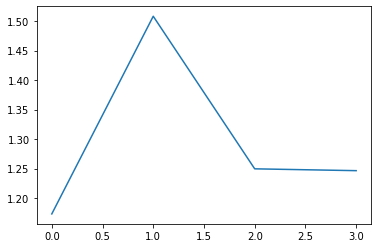

In [ ]:
fit(resnet, epochs=4)

In [ ]:
resnet.load_state_dict(best_model)
print(f'train acc : {evaluation(trainloader, resnet):0.2f} test acc : {evaluation(testloader, resnet):0.2f}')

## Inception - has two outputs

https://pytorch.org/vision/main/_modules/torchvision/models/inception.html

In [ ]:
inception = models.inception_v3(pretrained=True)
print(inception)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
for param in inception.parameters():
  param.requires_grad = False

aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

for param in inception.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [ ]:
# We need to resize images for inception
transform_train = transforms.Compose([transforms.RandomSizedCrop(299),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                     ])
transform_train = transforms.Compose([transforms.RandomSizedCrop(299),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                     ])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:935: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +


In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', download=True,
                                        train=True,
                                        transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='./data', download=True,
                                        train=False,
                                        transform=transform_train)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
batch_size=16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)

minimum loss : 3.1692874431610107
minimum loss : 3.019541025161743
minimum loss : 2.9915475845336914
minimum loss : 2.795999050140381
minimum loss : 2.741861343383789
minimum loss : 2.7210168838500977
minimum loss : 2.6918206214904785
minimum loss : 2.688307762145996
minimum loss : 2.60568904876709
minimum loss : 2.5921578407287598
iteration 100/3125.0,epoch 1/4, loss: 2.868778705596924
minimum loss : 2.557013511657715
minimum loss : 2.5491814613342285
minimum loss : 2.46052885055542
minimum loss : 2.3653199672698975
minimum loss : 2.323638677597046
iteration 200/3125.0,epoch 1/4, loss: 2.7479758262634277
minimum loss : 2.150982618331909
minimum loss : 1.955122947692871
iteration 300/3125.0,epoch 1/4, loss: 2.306257724761963
iteration 400/3125.0,epoch 1/4, loss: 2.4003782272338867
minimum loss : 1.952438473701477
minimum loss : 1.8912830352783203
minimum loss : 1.876891851425171
minimum loss : 1.7203809022903442
iteration 500/3125.0,epoch 1/4, loss: 2.3399364948272705
iteration 600/312

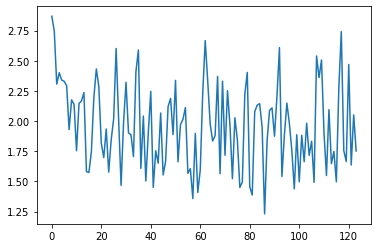

In [ ]:
fit_inception(inception, epochs=4)

In [ ]:
inception.load_state_dict(best_model)
print(f'train acc : {evaluation_inception(trainloader, inception):0.2f} test acc : {evaluation_inception(testloader, inception):0.2f}')

train acc : 48.65 test acc : 48.08


## SqueezeNet - Smaller and Faster than VGG or AlexNet

In [ ]:
squeezenet = models.squeezenet1_0(pretrained=True)
print(squeezenet)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [ ]:
squeezenet.classifier[3]

AdaptiveAvgPool2d(output_size=(1, 1))

In [ ]:
squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

In [ ]:
# mod_classifier = list(squeezenet.classifier.children())
# mod_classifier.append(nn.Linear(4000, num_classes))
# squeezenet.classifier = nn.Sequential(*mod_classifier)

In [ ]:
input, label = next(iter(trainloader))
squeezenet(input).shape

torch.Size([4, 10])

In [ ]:
for param in squeezenet.parameters():
  param.requires_grad = False

squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

for param in squeezenet.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 512, 1, 1])
torch.Size([10])


In [ ]:
squeezenet = squeezenet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)

In [ ]:
fit(squeezenet, epochs=4)

minimum loss : 2.502241611480713
minimum loss : 2.456125020980835
minimum loss : 1.7479634284973145
minimum loss : 1.568948745727539
iteration 100/12500.0,epoch 1/4, loss: 2.5477378368377686
iteration 200/12500.0,epoch 1/4, loss: 2.802395820617676
iteration 300/12500.0,epoch 1/4, loss: 2.2720394134521484
iteration 400/12500.0,epoch 1/4, loss: 2.453176975250244
iteration 500/12500.0,epoch 1/4, loss: 2.086589813232422
iteration 600/12500.0,epoch 1/4, loss: 2.304422616958618
iteration 700/12500.0,epoch 1/4, loss: 2.1495704650878906
iteration 800/12500.0,epoch 1/4, loss: 2.5836243629455566
iteration 900/12500.0,epoch 1/4, loss: 2.4131386280059814
iteration 1000/12500.0,epoch 1/4, loss: 2.638308525085449
iteration 1100/12500.0,epoch 1/4, loss: 2.2977893352508545
iteration 1200/12500.0,epoch 1/4, loss: 2.6259169578552246
iteration 1300/12500.0,epoch 1/4, loss: 2.7334208488464355
iteration 1400/12500.0,epoch 1/4, loss: 2.576516628265381
minimum loss : 1.3184564113616943
iteration 1500/12500.0

NameError: ignored

In [ ]:
squeezenet.load_state_dict(best_model)
print(f'train acc : {evaluation(trainloader, squeezenet):0.2f} test acc : {evaluation(testloader, squeezenet):0.2f}')

train acc : 7.89 test acc : 8.00


# Visualising CNNs

## Loading Data

In [ ]:
# !unzip data.zip

In [ ]:
# print(classes)

In [ ]:
# with open('data/imagenet_labels.txt') as f:
#   classes = eval(f.read())
# print(classes)

In [ ]:
transform = transforms.Compose([transforms.Resize(224),
                               transforms.ToTensor(),
                               transforms.Normalize((0.845,0.456,0.406), (0.229,0.224,0.225))
                               ])

In [ ]:
num_classes = 10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
# evalset = torchvision.datasets.ImageFolder(root='./data/imagenet', transform=transform)
evalset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [ ]:
batch_size = 1
evalloader = torch.utils.data.DataLoader(evalset, batch_size=batch_size, shuffle=True)

In [ ]:
images, labels = next(iter(evalloader))
print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
2


## Loading model

In [ ]:
model = models.vgg16(pretrained=True)

In [ ]:
in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, num_classes)

In [ ]:
# setting in eval mode
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Visualise Image

In [ ]:
def imshow(img, title):

  std_correction =  np.asarray([0.229, 0.224, 0.225]).reshape(3,1,1)
  mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3,1,1)
  npimg = np.multiply(img.numpy(), std_correction) + mean_correction # un normalising

  plt.figure(figsize=(batch_size*4,4))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.title(title)
  plt.show()

def imbatch_show(dataloader, model):
  images, labels = next(iter(dataloader))
  print(classes[labels])
  outputs = model(images)
  pred = torch.argmax(outputs.data, axis=1)
  
  img = torchvision.utils.make_grid(images)
  imshow(img, title=[str(x.item()) for x in labels])

  return images, pred

ship


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


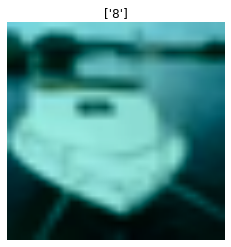

dog
torch.Size([1, 3, 224, 224])


In [ ]:
images, pred = imbatch_show(evalloader, model)
print(classes[pred])
print(images.shape)

## Occlusion Analysis

In [ ]:
outputs = model(images)
print(outputs.shape)
outputs = nn.functional.softmax(outputs, dim=1)
prob_no_occ, pred = torch.max(outputs.data, axis=1)
prob_no_occ = prob_no_occ[0].item()
print('prob without occlusion : ', prob_no_occ)

torch.Size([1, 10])
prob without occlusion :  0.1417291909456253


In [ ]:
def occlusion(model, image, label, occ_size=50, occ_stride=50, occ_pixel=0.5):
  width, height = image.shape[-2], image.shape[-1]

  output_height = int(np.ceil((height-occ_size)/occ_stride))
  output_width  = int(np.ceil((width-occ_size)/occ_stride))

  heatmap = torch.zeros(output_height, output_width)

  for h in range(0,height):
    for w in range(0,width):

      h_start = h*occ_stride
      w_start = w*occ_stride
      h_end = min(height, h_start + occ_size)
      w_end = min(width, w_start + occ_size)

      if w_end >= width or h_end >= height:
        continue
      
      input_image = image.clone().detach()
      input_image[:,:, w_start:w_end, h_start:h_end] = occ_pixel

      output = model(input_image)
      output = nn.functional.softmax(output, dim=1)
      # print(output.shape)
      prob = list(output)[0][label]

      heatmap[h,w] = prob
  return heatmap.detach().numpy()

In [ ]:
print(images.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
heatmap = occlusion(model, images, pred[0].item(), 28,28)

In [ ]:
imgplot = sns.heatmap(heatmap, vmax=prob_no_occ, xticklabels=False, yticklabels=False)

## Filter Visualisation

**Warning**: Errors Ahead

In [ ]:
alexnet = models.alexnet(pretrained=True)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
def plot_weights(model, layer_num, single_channel=True, collated=False):
  layer = model.features[layer_num]
  if isinstance(layer, nn.Conv2d):
    weight_tensor = model.features[layer_num].weight.data
    print(weight_tensor.shape)
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        'Can only plot weights with three channels if single_channel = False'
  else:
      print('Can only visualise layers which are convolutional')

In [ ]:
def plot_filters_multi_channel(weight_tensor):
  num_kernels = weight_tensor.shape[0]

  num_cols=12
  num_rows = num_kernels

  fig = plt.figure(figsize=(num_cols, num_rows))
  for i in range(weight_tensor.shape[0]):
    ax1 = fig.add_subplot(num_rows, num_cols, i+1)
    npimg = np.array(weight_tensor.numpy(), np.float32)
    npimg = (npimg-np.mean(npimg))/np.std(npimg)
    npimg = np.minimum(1,np.maximum(0,npimg+0.5))
    npimg = npimg.transpose((1,2,0))
    ax1.imshow(npimg)
    ax1.axis('off')
    ax1.set_title(str(i))
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
  
  plt.tight_layout()
  plt.show()

In [ ]:
def plot_filters_single_channel_big(weight_tensor):

  n_rows = weight_tensor.shape[0]*weight_tensor.shape[2]
  n_cols = weight_tensor.shape[1]*weight_tensor.shape[3]

  npimg = np.array(weight_tensor.numpy(), np.float32)
  npimg = npimg.transpose((0,2,1,3))
  npimg = npimg.ravel().reshape(n_rows, n_cols)
  npimg = npimg.T

  fig, ax = plt.subplots(fifsize=(n_cols/10, n_rows/200))
  imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='Greys', ax=ax, cbar=False)

In [ ]:
def plot_filters_single_channel(weight_tensor):

  num_plots = weight_tensor.shape[0]*weight_tensor.shape[1]
  num_cols=12
  num_rows = 1+ num_plots//num_cols

  npimg = np.array(weight_tensor.numpy(), np.float32)
  count=0

  fig = plt.figure(figsize=(num_cols, num_rows))
  for i in range(weight_tensor.shape[0]):
    for j in range(weight_tensor.shape[1]):
      count += 1
      ax1 = fig.add_subplot(num_rows, num_cols, count)
      npimg = np.array(weight_tensor[i,j].numpy(), np.float32)
      npimg = (npimg-np.mean(npimg))/np.std(npimg)
      npimg = np.minimum(1,np.maximum(0,npimg+0.5))
      ax1.imshow(npimg)
      ax1.axis('off')
      ax1.set_title(f'{i},{j}')
      ax1.set_xticklabels([])
      ax1.set_yticklabels([])
  
  plt.tight_layout()
  plt.show()

torch.Size([64, 3, 11, 11])


ValueError: ignored

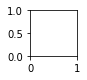

In [ ]:
plot_weights(alexnet, 0, single_channel=False)

# Batch Normalisation and Dropout

## Data Loading

In [ ]:
transform_train = transforms.Compose([transforms.ToTensor()])

In [ ]:
trainset = torchvision.datasets.MNIST(root='./data', 
                                      train=True, 
                                      download=True, 
                                      transform=transform_train)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
batch_size=4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [ ]:
images, labels = next(iter(trainloader))
print(images.shape)
print(labels.shape)
print(labels)

torch.Size([4, 1, 28, 28])
torch.Size([4])
tensor([7, 3, 5, 3])


In [ ]:
def imshow(img, title):
  npimg = img.numpy()/2 + 0.5 # img * std + mean (un normalising)
  plt.figure(figsize=(batch_size, 1))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.title(title)
  plt.show()

def imbatch_show(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title=[str(x.item()) for x in labels])

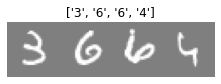

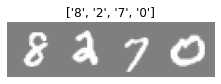

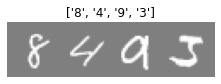

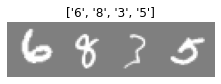

In [ ]:
for i in range(4):
  imbatch_show(trainloader)

## Batch norm

In [ ]:
class MyNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.classifier = nn.Sequential(nn.Linear(784,48), # 784 = 28*28
                                    nn.ReLU(),
                                    nn.Linear(48,24),
                                    nn.ReLU(),
                                    nn.Linear(24,10))
  
  def forward(self,x):
    x = x.view(x.shape[0],-1)
    x = self.classifier(x)
    return x

In [ ]:
class MyNetBN(nn.Module):
  def __init__(self):
    super().__init__()
    self.classifier = nn.Sequential(nn.Linear(784,48),
                                    nn.BatchNorm1d(48),
                                    nn.ReLU(),
                                    nn.Linear(48,24),
                                    nn.BatchNorm1d(24),
                                    nn.ReLU(),
                                    nn.Linear(24,10))
  
  def forward(self,x):
    x = x.view(x.shape[0],-1)
    x = self.classifier(x)
    return x

In [ ]:
model = MyNet()
print(model)

MyNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [ ]:
model_bn = MyNetBN()
print(model_bn)

MyNetBN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [ ]:
batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
opt    =  optim.SGD(model_bn.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

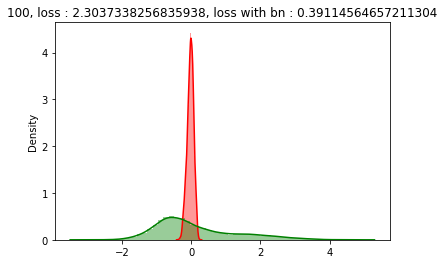

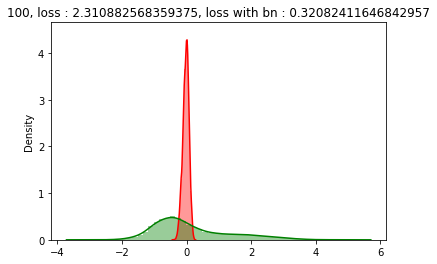

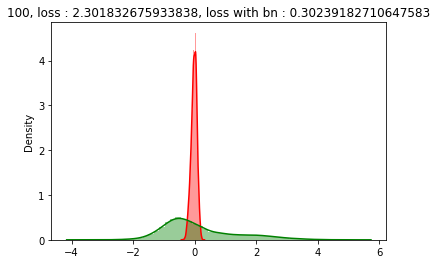

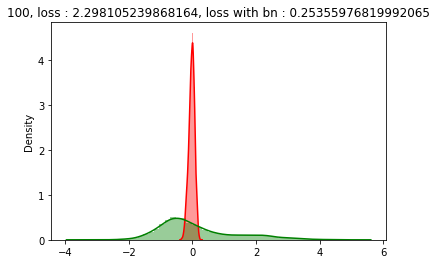

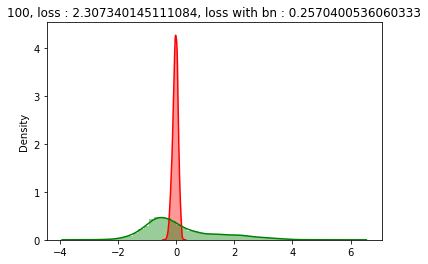

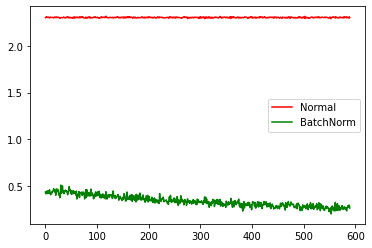

In [ ]:
max_epochs = 5
losses = []
losses_bn=[]
i=0

for epoch in range(1,max_epochs+1):
  i=0
  for inputs, labels in trainloader:
    i+=1

    #training normal model
    opt.zero_grad()    
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    #training batch normalised moe
    opt_bn.zero_grad()    
    outputs = model_bn(inputs)
    loss_bn = loss_fn(outputs, labels)
    loss_bn.backward()
    opt_bn.step()

    losses.append(loss.item())
    losses_bn.append(loss_bn.item())

    if i%20 == 0:
      inputs = inputs.view(inputs.shape[0],-1)

      model.eval()
      model_bn.eval()

      a = model.classifier[0](inputs)
      a = model.classifier[1](a)
      a = model.classifier[2](a)
      a = a.detach().numpy().ravel()
      sns.distplot(a, kde=True, color='r', label='Normal')

      b = model_bn.classifier[0](inputs)
      b = model_bn.classifier[1](b)
      b = model_bn.classifier[2](b)
      b = model_bn.classifier[3](b)
      b = model_bn.classifier[4](b)
      b = b.detach().numpy().ravel()
      sns.distplot(b, kde=True, color='g', label='BatchNorm')

      plt.title(f'{i}, loss : {loss.item()}, loss with bn : {loss_bn.item()}')
      plt.show()
      plt.pause(0.5)

      model.train()
      model_bn.train()

plt.plot(losses,'r', label='Normal')
plt.plot(losses_bn, 'g', label='BatchNorm')
plt.legend()
plt.show()

class My

In [ ]:
class CNN_BN(nn.Module):
  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(nn.Conv2d(1,3,5),          # (N, 1, 28, 28) -> (N, 3, 24, 24)
                                  nn.ReLU(),
                                  nn.AvgPool2d(2, stride=2), # (N, 3, 24, 24) -> (N, 3, 12, 12)
                                  nn.Conv2d(3,6,3),          # (N, 3, 12, 12) -> (N, 6, 10, 10)
                                  nn.BatchNorm2d(6)
                                  )
    self.features1 = nn.Sequential(nn.ReLU(),
                                   nn.AvgPool2d(2, stride=2) # (N, 6, 10, 10) -> (N, 6, 5, 5)
                                  )
    self.classifier = nn.Sequential(nn.Linear(150,25),       # (N, 150) -> (N, 25)
                                    nn.ReLU(),
                                    nn.Linear(25,10)         # (N, 25) -> (N, 10)
                                    )
  
  def forward(self,x):
    x = self.features(x)
    x = self.features1(x)
    x = x.view(x.shape[0],-1)
    x = self.classifier(x)
    return x

## Dropout

In [ ]:
N = 25
noise = 0.3

X_train = torch.unsqueeze(torch.linspace(-1,1,N), dim=1)
Y_train = X_train + noise * torch.normal(torch.zeros(N,1), torch.ones(N,1))

X_test = torch.unsqueeze(torch.linspace(-1,1,N), dim=1)
Y_test = X_test + noise * torch.normal(torch.zeros(N,1), torch.ones(N,1))

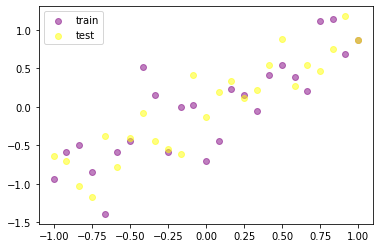

In [ ]:
plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', alpha=0.5, label='train')
plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
plt.legend()
plt.show()

In [ ]:
N_h = 100

#simple network
model = nn.Sequential(nn.Linear(1,N_h),
                      nn.ReLU(),
                      nn.Linear(N_h, N_h),
                      nn.ReLU(),
                      nn.Linear(N_h, 1)
                      )

#network with dropout
model_dropout = nn.Sequential(nn.Linear(1,N_h),
                              nn.Dropout(0.5),
                              nn.ReLU(),
                              nn.Linear(N_h, N_h),
                              nn.Dropout(0.5),
                              nn.ReLU(),
                              nn.Linear(N_h, 1)
                              )

In [ ]:
loss_fn = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=0.01)
opt_dropout = optim.Adam(model_dropout.parameters(), lr=0.01)

In [ ]:
max_epochs = 100
losses = []
losses_dropout=[]
i=0
inputs = X_train
labels = Y_train

for epoch in range(1,max_epochs+1):

  #training normal model
  opt.zero_grad()    
  outputs = model(inputs)
  loss = loss_fn(outputs, labels)
  loss.backward()
  opt.step()

  #training batch normalised moe
  opt_dropout.zero_grad()    
  outputs = model_dropout(inputs)
  loss_dropout = loss_fn(outputs, labels)
  loss_dropout.backward()
  opt_dropout.step()

  losses.append(loss.item())
  losses_dropout.append(loss_dropout.item())

  if i%50 == 0:
    inputs = inputs.view(inputs.shape[0],-1)

    model.eval()
    model_dropout.eval()

    test_pred = model(X_test)
    test_pred_dropout = model_dropout(X_test)

    test_loss = loss_fn(test_pred, Y_test)
    test_loss_dropout = loss_fn(test_pred_dropout, Y_test)

    plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', alpha=0.5, label='train')
    plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
    plt.plot(X_test.data.numpy(), test_pred.data.numpy(), 'r-', lw=3, label='normal')
    plt.plot(X_test.data.numpy(), test_pred_dropout.data.numpy(), 'b--', lw=3, label='dropout')

    plt.legend()
    plt.title(f'{epoch}, test loss : {test_loss.item()}, loss with dropout : {test_loss_dropout.item()}')
    plt.show()
    plt.pause(0.5)

    model.train()
    model_dropout.train()

plt.plot(losses,'r', label='Normal')
plt.plot(losses_dropout, 'g', label='dropout')
plt.legend()
plt.show()

# Hyperparameter Tuning

## Outline
1. Integrate Google Collab with local runtime
2. Installing MLFlow and basic usecase
3. Logging parameters with MLFlow
4. Loging image artifacts with MLFlow
5. Logging PyTorch models with MLFlow and loading them

__Hyperparameters__
1. Network Design : 
    * num layers
    * num neurons
    * activation functions
    * type of layers
    * filter sizes, etc.
2. Optimisation Algorithm :
    * type of algorithm
    * learning rate
    * momentum
    * batch size
    * epochs
    * nesterov acceleration, etc.

## Connect to local runtime

recommended to use conda to install jupyter notebook

open mlflow and jupyter in the same folder

https://mlflow.org/

https://research.google.com/colaboratory/local-runtimes.html

http://localhost:5000/

Run these commands on different conda shells and open resulting links in browser

    jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

    mlflow ui

In [ ]:
class Params:
  def __init__(self, batch_size, epochs, seed, log_interval):
    self.batch_size = batch_size
    self.epochs = epochs
    self.seed = seed
    self.log_interval = log_interval

args = Params(253,4,0,20)

## Data Loading

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.1307,), (0.3081,))
                                 ])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset, batch_size=args.batch_size, shuffle=False)

In [ ]:
class Model(nn.Module):
  def __init__(self, N_h= 32):
    super().__init__()
    self.N_h = N_h
    self.classifier = nn.Sequential(nn.Linear(784, N_h),
                                    nn.ReLU(),
                                    nn.Linear(N_h, 10)
                                    )
  def forward(self,x):
    x = x.view(x.size(0),-1)
    x = self.classifier(x)
    return x

In [ ]:
len(trainloader.dataset) #no. of samples

60000

In [ ]:
len(trainloader) #no. of batches

238

In [ ]:
model = Model(3)
inputs, labels = next(iter(trainloader))
outputs = model(inputs)
print(outputs.shape)
print(outputs.data.shape)

#the following three are the same stuff
print(outputs.data.max(1)[1])
print(outputs.data.argmax(dim=1))
print(torch.argmax(outputs.data, dim=1))

torch.Size([253, 10])
torch.Size([253, 10])
tensor([2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
        2, 1, 2, 2, 2, 2, 2, 2, 2, 5, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 9, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, 2,
        2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2,
        2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 9,
        1, 2, 2, 2, 2, 2, 2, 9, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2,
        9, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 5,
        2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 1, 2, 2, 9, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 7, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2])
tensor([2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
        2, 1, 2, 2, 2, 2, 2,

In [ ]:
def train(epoch):
  model.train()

  batch_id=0
  l = len(trainloader)
  for inputs, labels in trainloader:
    batch_id+=1

    opt.zero_grad()    
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    if batch_id%args.log_interval == 0:
      pos = epoch*l + batch_id
      mlflow.log_metric('train loss', 1000*loss.item()/len(inputs))
      print(f'Epoch {epoch} [{batch_id*len(inputs)}/{len(trainloader.dataset)}, {100*batch_id/l} loss : {loss.item()}')

def test(epoch):
  model.eval()
  test_loss=0
  correct=0
  confusion_matrix = np.zeros([10,10])

  batch_id=0
  l = len(testloader)

  with torch.no_grad():
    for inputs, labels in testloader:

      outputs = model(inputs)
      test_loss += loss_fn(outputs, labels).data.item()
      pred = outputs.data.max(1)[1]
      correct += pred.eq(labels.data).sum().item()

      for x, y in zip(pred.numpy(), labels.numpy()):
        confusion_matrix[x][y] += 1
    
    test_loss /= len(testloader.dataset)
    test_accuracy = 100*correct/len(testloader.dataset)

    pos = (epoch+1)*len(trainloader) 
    mlflow.log_metric('test loss', 1000*test_loss)
    mlflow.log_metric('test_accuracy', test_accuracy)
    print(f'Average Loss : {test_loss: 0.4f} Accuracy : {correct}/{len(testloader.dataset)} {test_accuracy:.0f}')

    if epoch==args.epochs:
      classes = np.arange(10)
      fig, ax = plt.subplots()
      im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
      ax.figure.colorbar(im, ax=ax)
      ax.set(xticks=np.arange(confusion_matrix.shape[1]),
             yticks=np.arange(confusion_matrix.shape[0]),
             ylabel='True label',
             xlabel='Predicted label',
             title=f'Epoch {epoch}'
             )
      thresh = confusion_matrix.max()/2
      for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
          ax.text(j,i, int(confusion_matrix[i,j]),
                  ha='center', va='center',
                  color='white' if confusion_matrix[i,j]>thresh else 'black')
      fig.tight_layout()

      imagepath = f'images/{expt_id}.png'
      plt.savefig(imagepath)
      mlflow.log_artifact(imagepath)

  

## Hyperparameter Training

In [ ]:
args.epochs = 8

2022/04/14 09:06:15 INFO mlflow.tracking.fluent: Experiment with name 'Check hidden nodes' does not exist. Creating a new experiment.



LR = 0.01, Momentum = 0.90, Hidden nodes = 16

Epoch 1 [5060/60000, 8.403361344537815 loss : 1.2869713306427002
Epoch 1 [10120/60000, 16.80672268907563 loss : 0.5881226062774658
Epoch 1 [15180/60000, 25.210084033613445 loss : 0.5286796689033508
Epoch 1 [20240/60000, 33.61344537815126 loss : 0.3086845278739929
Epoch 1 [25300/60000, 42.016806722689076 loss : 0.4286341667175293
Epoch 1 [30360/60000, 50.42016806722689 loss : 0.29361575841903687
Epoch 1 [35420/60000, 58.8235294117647 loss : 0.3855561316013336
Epoch 1 [40480/60000, 67.22689075630252 loss : 0.32850179076194763
Epoch 1 [45540/60000, 75.63025210084034 loss : 0.3045528829097748
Epoch 1 [50600/60000, 84.03361344537815 loss : 0.26362571120262146
Epoch 1 [55660/60000, 92.43697478991596 loss : 0.3327578902244568
Average Loss :  0.0012 Accuracy : 9155/10000 92
Epoch 2 [5060/60000, 8.403361344537815 loss : 0.4248356223106384
Epoch 2 [10120/60000, 16.80672268907563 loss : 0.19260069727897644
Epoch 2 [15180/60000, 25.210084033613445 lo

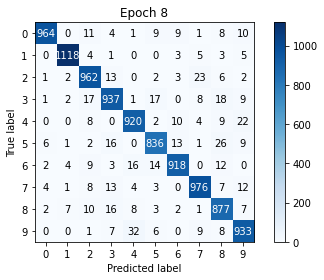

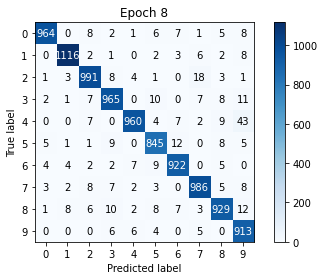

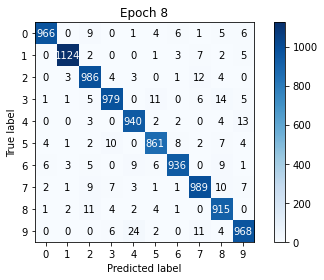

In [ ]:
mlflow.set_experiment('Check hidden nodes')
for lr in [0.01]:#,0.05,0.1]:
  for momentum in [0.9]:#,0.92,0.95]:
    for hidden_nodes in [16,32,48]:

      expt_id = f'{int(lr*100)}_{int(momentum*100)}_{hidden_nodes}'
      print(f'\nLR = {lr:0.2f}, Momentum = {momentum:0.2f}, Hidden nodes = {hidden_nodes}\n')

      model = Model(hidden_nodes)
      loss_fn = nn.CrossEntropyLoss()
      opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

      with mlflow.start_run() as run:
        for key,value in vars(args).items():
          mlflow.log_param(key,value)
        mlflow.log_param('lr',lr)
        mlflow.log_param('momentum', momentum)
        mlflow.log_param('hidden_nodes', hidden_nodes)

        for epoch in range(1,args.epochs+1):
          train(epoch)
          test(epoch)
          mlflow.pytorch.log_model(model, 'models')

2022/04/14 09:21:49 INFO mlflow.tracking.fluent: Experiment with name 'Fixed nH' does not exist. Creating a new experiment.



LR = 0.01, Momentum = 0.90, Hidden nodes = 48

Epoch 1 [5060/60000, 8.403361344537815 loss : 1.1930183172225952
Epoch 1 [10120/60000, 16.80672268907563 loss : 0.5448200702667236
Epoch 1 [15180/60000, 25.210084033613445 loss : 0.3275856375694275
Epoch 1 [20240/60000, 33.61344537815126 loss : 0.3991808295249939
Epoch 1 [25300/60000, 42.016806722689076 loss : 0.32442206144332886
Epoch 1 [30360/60000, 50.42016806722689 loss : 0.46555793285369873
Epoch 1 [35420/60000, 58.8235294117647 loss : 0.3713659346103668
Epoch 1 [40480/60000, 67.22689075630252 loss : 0.2134162187576294
Epoch 1 [45540/60000, 75.63025210084034 loss : 0.4372745156288147
Epoch 1 [50600/60000, 84.03361344537815 loss : 0.25240689516067505
Epoch 1 [55660/60000, 92.43697478991596 loss : 0.3139038681983948
Average Loss :  0.0011 Accuracy : 9218/10000 92
Epoch 2 [5060/60000, 8.403361344537815 loss : 0.24484439194202423
Epoch 2 [10120/60000, 16.80672268907563 loss : 0.3423042893409729
Epoch 2 [15180/60000, 25.210084033613445 lo

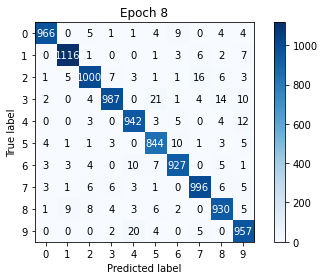

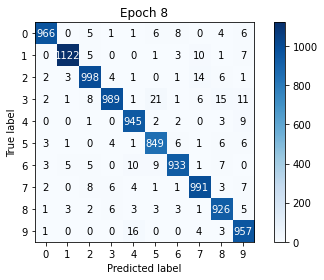

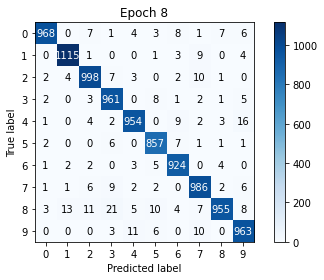

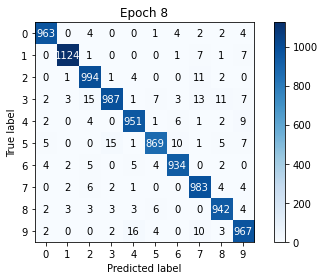

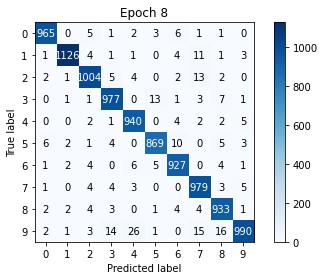

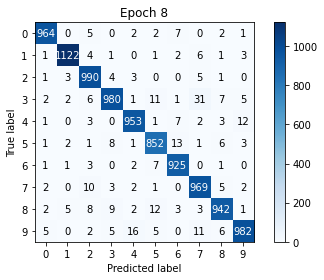

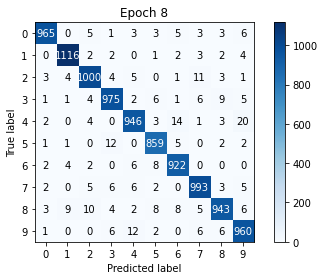

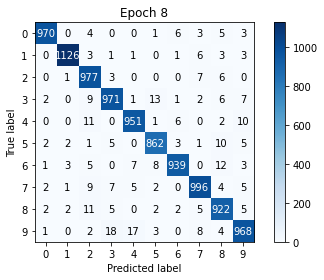

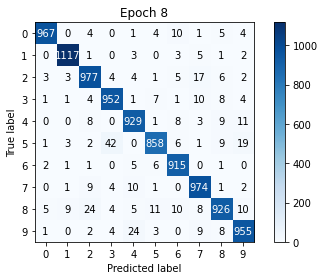

In [ ]:
mlflow.set_experiment('Fixed nH')
for lr in [0.01,0.05,0.1]:
  for momentum in [0.9,0.92,0.95]:
    for hidden_nodes in [48]:

      expt_id = f'{int(lr*100)}_{int(momentum*100)}_{hidden_nodes}'
      print(f'\nLR = {lr:0.2f}, Momentum = {momentum:0.2f}, Hidden nodes = {hidden_nodes}\n')

      model = Model(hidden_nodes)
      loss_fn = nn.CrossEntropyLoss()
      opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

      with mlflow.start_run() as run:
        for key,value in vars(args).items():
          mlflow.log_param(key,value)
        mlflow.log_param('lr',lr)
        mlflow.log_param('momentum', momentum)
        mlflow.log_param('hidden_nodes', hidden_nodes)

        for epoch in range(1,args.epochs+1):
          train(epoch)
          test(epoch)
          mlflow.pytorch.log_model(model, 'models')

In [ ]:
# model_load = mlflow.pytorch.load_model('models', run_id='a6820f3ca0704fe8bd63a181d0e8e8d6') #this didn't work
model_load = mlflow.pytorch.load_model('file:///D:/ProgramData/python%20workspace/mlruns/1/9bcbd339228e46f1bfadb12c1427b192/artifacts/models') #path copied from mlflow ui

In [ ]:
weight_layer0 = list(model_load.parameters())[0].data.numpy()

[]

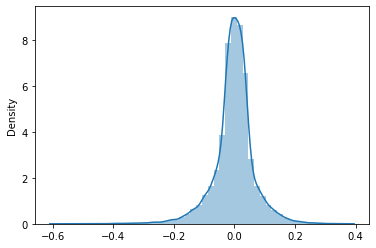

In [ ]:
sns.distplot(weight_layer0.ravel())
plt.plot()

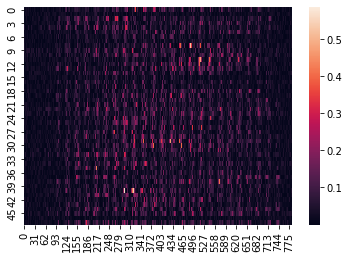

In [ ]:
sns.heatmap(np.abs(weight_layer0))
plt.show()

In [ ]:
weight_layer1 = list(model_load.parameters())[2].data.numpy()

In [ ]:
weight_layer1.shape

(10, 48)

[]

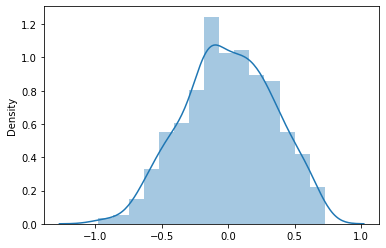

In [ ]:
sns.distplot(weight_layer1.ravel())
plt.plot()

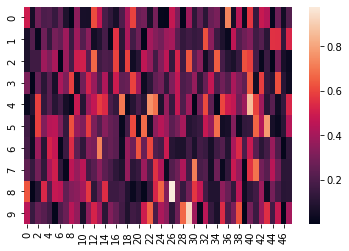

In [ ]:
sns.heatmap(np.abs(weight_layer1))
plt.show()

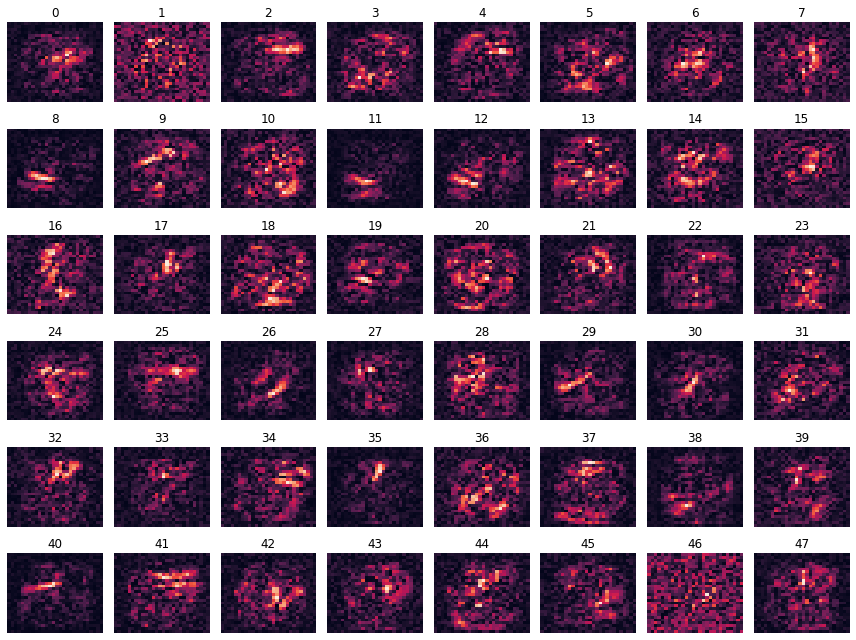

In [ ]:
# what each neuron in hidden layer learns
nrows = 6
ncols = 8
fig = plt.figure(figsize=(1.5*ncols, 1.5*nrows))

for i in np.arange(48):
  ax1 = fig.add_subplot(nrows, ncols, i+1)
  sns.heatmap(np.abs(weight_layer0[i,0:784]).reshape(28,28), ax=ax1, cbar=False)
  ax1.axis('off')
  ax1.set_xticklabels([])
  ax1.set_yticklabels([])
  ax1.set_title(i)
plt.tight_layout()
plt.show()